In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [31]:
data = pd.read_csv('./train.csv')

In [32]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [33]:
#1 Посмотрим на первые пять строк
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [34]:
#2 Проверим незаполненные значения. Таковых нет
data.isna().values.any()

False

In [40]:
numeric_data = data[num_cols]
categorical_data = data[cat_cols]

numeric_data.head()

,ClientPeriod,MonthlySpending,TotalSpent
0,55,19.50,1026.35
1,72,25.85,1872.2
2,1,75.90,75.9
3,32,79.30,2570
4,60,115.25,6758.45


array([[<AxesSubplot:title={'center':'ClientPeriod'}>,
        <AxesSubplot:title={'center':'MonthlySpending'}>]], dtype=object)

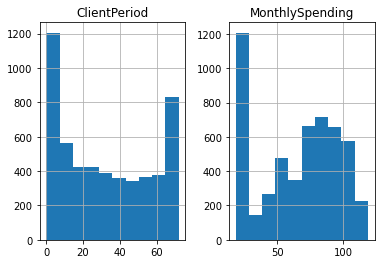

In [49]:
numeric_data.hist()